In [9]:
import numpy as np
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm, trange

In [10]:
S4b_train = np.load('./data/S4b_train.npz')
X11b_train = np.load('./data/X11b_train.npz')
S4b_test = np.load('./data/S4b_test.npz')
X11b_test = np.load('./data/X11b_test.npz')

train_data = np.concatenate((S4b_train['signal'], X11b_train['signal']), axis=0)
train_label = np.concatenate((S4b_train['label'], X11b_train['label']), axis=0)
test_data = np.concatenate((S4b_test['signal'], X11b_test['signal']), axis=0)
test_label = np.concatenate((S4b_test['label'], X11b_test['label']), axis=0)

train_label = train_label - 1
test_label = test_label -1
train_data = np.transpose(np.expand_dims(train_data, axis=1), (0, 1, 3, 2))
test_data = np.transpose(np.expand_dims(test_data, axis=1), (0, 1, 3, 2))

mask = np.where(np.isnan(train_data))
train_data[mask] = np.nanmean(train_data)

mask = np.where(np.isnan(test_data))
test_data[mask] = np.nanmean(test_data)

print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)


In [11]:
class ImgDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        x = self.X[index]
        y = self.Y[index]
        return x, y
    
batch_size = 64
train_set = ImgDataset(train_data, train_label)
val_set = ImgDataset(test_data, test_label)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)

In [12]:
class EEGNet(nn.Module):
    def __init__(self, activation=nn.ReLU()):
        super(EEGNet, self).__init__()
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, 16, (1, 51), (1, 1), (0, 25), bias=False),
            nn.BatchNorm2d(16),
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, (2, 1), (1, 1), groups=16, bias=False),
            nn.BatchNorm2d(32),
            activation,
            nn.AvgPool2d((1, 4)),
            nn.Dropout(0.5),
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, (1, 15), (1, 1), (0, 7), bias=False),
            nn.BatchNorm2d(32),
            activation,
            nn.AvgPool2d((1, 8)),
            nn.Dropout(0.5),
        )
        self.classify = nn.Sequential(
            nn.Linear(736, 2)
        )
        
    
    def forward(self, x):
        out = self.firstconv(x)
        out = self.depthwiseConv(out)
        out = self.separableConv(out)
        out = out.view(out.size()[0], -1)
        return self.classify(out)

model = EEGNet()
print(model)

EEGNet(
  (firstconv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (depthwiseConv): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.5, inplace=False)
  )
  (separableConv): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (4): Dropout(p=0.5, inplace=False)
  )
  (classify): Sequential(
    (0): Linear(in_features=736, out_features=2, bias=True)
  )
)


In [13]:
class DeepConvNet(nn.Module):
    def __init__(self, activation=nn.ReLU()):
        super(DeepConvNet, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 25, (1, 5)),
            nn.Conv2d(25, 25, (2, 1)),
            nn.BatchNorm2d(25),
            activation,
            nn.MaxPool2d((1, 2)),
            nn.Dropout(0.5),
            nn.Conv2d(25, 50, (1, 5)),
            nn.BatchNorm2d(50),
            activation,
            nn.MaxPool2d((1, 2)),
            nn.Dropout(0.5),
            nn.Conv2d(50, 100, (1, 5)),
            nn.BatchNorm2d(100),
            activation,
            nn.MaxPool2d((1, 2)),
            nn.Dropout(0.5),
            nn.Conv2d(100, 200, (1, 5)),
            nn.BatchNorm2d(200),
            activation,
            nn.MaxPool2d((1, 2)),
            nn.Dropout(0.5),
        )
        self.fc = nn.Linear(8600, 2)
        
    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)
        
model = DeepConvNet().cuda()
print(model)

DeepConvNet(
  (cnn): Sequential(
    (0): Conv2d(1, 25, kernel_size=(1, 5), stride=(1, 1))
    (1): Conv2d(25, 25, kernel_size=(2, 1), stride=(1, 1))
    (2): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
    (6): Conv2d(25, 50, kernel_size=(1, 5), stride=(1, 1))
    (7): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (10): Dropout(p=0.5, inplace=False)
    (11): Conv2d(50, 100, kernel_size=(1, 5), stride=(1, 1))
    (12): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.5, inplace=False)
    (16):

  0%|          | 0/3000 [00:00<?, ?it/s]

EEGNet_relu best test accuracy: 88.98%
EEGNet_leaky_relu best test accuracy: 89.07%
EEGNet_elu best test accuracy: 82.31%


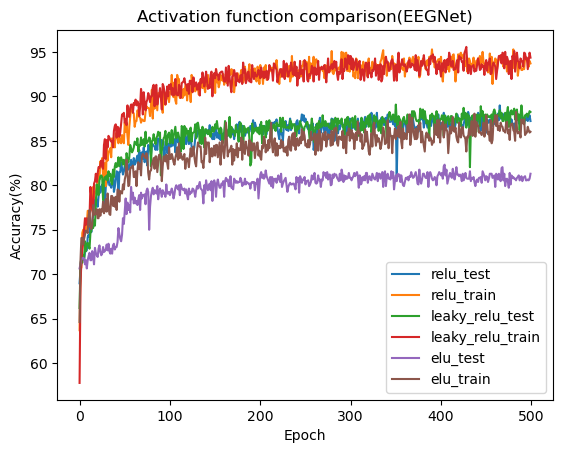

DeepConvNet_relu best test accuracy: 84.54%
DeepConvNet_leaky_relu best test accuracy: 84.81%
DeepConvNet_elu best test accuracy: 81.67%


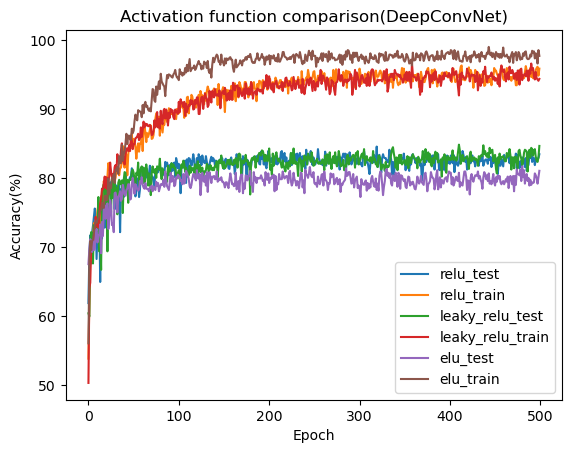

In [14]:
models = [EEGNet, DeepConvNet]
model_names = ['EEGNet', 'DeepConvNet']
activations = [nn.ReLU(), nn.LeakyReLU(), nn.ELU()]
activation_names = ['relu', 'leaky_relu', 'elu']

num_epoch = 500
progress = tqdm(total=num_epoch*6)
accuracy_list = list()
for idx1 in range(2):
    plt.figure()
    for idx2 in range(3):
        model = models[idx1](activations[idx2]).cuda()
        loss = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-3)
        
        best_accuracy = 0
        train_acc_list = list()
        val_acc_list = list()
        for epoch in range(num_epoch):
            epoch_start_time = time.time()
            train_acc = 0.0
            val_acc = 0.0

            model.train()
            for i, data in enumerate(train_loader):
                optimizer.zero_grad() 
                train_pred = model(data[0].type(torch.FloatTensor).cuda()) 
                batch_loss = loss(train_pred, data[1].type(torch.LongTensor).cuda())
                batch_loss.backward() 
                optimizer.step()

                train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())

            model.eval()
            with torch.no_grad():
                for i, data in enumerate(val_loader):
                    val_pred = model(data[0].type(torch.FloatTensor).cuda())
                    batch_loss = loss(val_pred, data[1].type(torch.LongTensor).cuda())

                    val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            
            train_acc_list.append(train_acc/train_set.__len__()*100)
            val_acc_list.append(val_acc/val_set.__len__()*100)
            progress.update(1)
            
            if val_acc/val_set.__len__()*100 > best_accuracy:
                best_accuracy = val_acc/val_set.__len__()*100
                # torch.save(model.state_dict(), f'./model/{model_names[idx1]}_{activation_names[idx2]}.pt')
                
            
        plt.plot(val_acc_list, label=f'{activation_names[idx2]}_test')
        plt.plot(train_acc_list, label=f'{activation_names[idx2]}_train')
        
        print(f'{model_names[idx1]}_{activation_names[idx2]} best test accuracy: {np.array(val_acc_list).max().round(2)}%')
        accuracy_list.append(np.array(val_acc_list).max().round(2))
        
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy(%)')
    plt.title(f'Activation function comparison({model_names[idx1]})')
    plt.legend()
    plt.show()

In [8]:
model = EEGNet(nn.LeakyReLU()).cuda()
model.load_state_dict(torch.load('./model/EEGNet_leaky_relu.pt'))
model.eval()
loss = nn.CrossEntropyLoss()

val_acc = 0.0
with torch.no_grad():
    for i, data in enumerate(val_loader):
        val_pred = model(data[0].type(torch.FloatTensor).cuda())
        batch_loss = loss(val_pred, data[1].type(torch.LongTensor).cuda())

        val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
    print(f'accuracy: {val_acc/val_set.__len__()*100}')

accuracy: 89.35185185185185
